In [1]:
import time
import os
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
browser = webdriver.Chrome()

browser.get("https://medium.com/topic/data-science")
time.sleep(1)

### Fetch all links on that page and filter them out

In [2]:
elem = browser.find_element_by_tag_name('body')
# print(elem)

no_of_pagedowns = 3000

while no_of_pagedowns:
    elem.send_keys(Keys.PAGE_DOWN)
    time.sleep(0.2)
    no_of_pagedowns-=1

    
post_elems = browser.find_elements_by_tag_name("a")

# for post in post_elems:
#     print(post.get_attribute('href'), len (post.get_attribute('href')))
post_relevant = [post for post in post_elems if len(post.get_attribute('href')) > 100]  
all_posts = []
for i in range(0, len(post_relevant), 3):
    all_posts.append(post_relevant[i].get_attribute('href'))
len(all_posts)

627

In [3]:
for post in all_posts:
    print(post)

https://medium.com/m/signin?redirect=https%3A%2F%2Fmedium.com%2Ftopic%2Fdata-science&source=--------------------------nav_reg&operation=login
https://towardsdatascience.com/python-is-the-perfect-tool-for-any-problem-f2ba42889a85?source=topic_page---8------0----------------
https://medium.com/google-news-lab/what-is-the-pizza-capital-of-the-us-8611a1ca6e41?source=topic_page---8------1----------------
https://towardsdatascience.com/dealing-with-imbalanced-classes-in-machine-learning-d43d6fa19d2?source=topic_page---8------2----------------
https://medium.com/@dpatil/a-code-of-ethics-for-data-science-cda27d1fac1?source=topic_page---8------3----------------
https://towardsdatascience.com/i-built-a-reject-not-reject-email-classifier-for-my-job-applications-844a3b6cd67e?source=topic_page---8------0----------------
https://towardsdatascience.com/fast-ai-the-best-things-in-life-are-always-free-3b05c54913cd?source=topic_page---8------1----------------
https://towardsdatascience.com/just-another-

### Iterate over every link and fetch relevant data

In [63]:
import ast
from datetime import datetime

data_scrapped = pd.DataFrame()
for i in range(1,len(all_posts)):
    r  = requests.get(all_posts[i])
    data = r.text
    soup = BeautifulSoup(data, 'html.parser')
    data_scrapped.loc[i-1,'title'] = soup.title.text[0:-23]
    data_scrapped.loc[i-1,'claps'] = soup.find('button', class_="button button--chromeless u-baseColor--buttonNormal js-multirecommendCountButton").text
    format = "%Y-%m-%d"
    data_scrapped.loc[i-1,'datePublished'] =  datetime.strptime(ast.literal_eval(soup.find('script').text)["datePublished"][0:10], format)
    data_scrapped.loc[i-1,'read_time'] = soup.find("span",class_ = "readingTime")['title'][:-9]
    

In [64]:
data_scrapped['para'] = [[]] * len(data_scrapped)
data_scrapped['tags'] = [[]] * len(data_scrapped)
data_scrapped['bullets'] = [[]] * len(data_scrapped)
data_scrapped['images'] = [[]] * len(data_scrapped)

In [37]:
para = []
tags = []
bullets = []
images = []
for i in range(1,len(all_posts)):
    r  = requests.get(all_posts[i])
    data = r.text
    soup = BeautifulSoup(data, 'html.parser')
    para.append( [hit.text.strip() for hit in soup.find_all('p')])
    tags.append( ast.literal_eval(soup.find('script').text)["keywords"])
    bullets.append( [hit.text.strip() for hit in soup.select('li[class*="graf graf--li"]')])
    images.append( soup.find_all('img', class_="graf-image"))

In [38]:
len(para), len(tags), len(bullets), len(images)

(626, 626, 626, 626)

In [65]:
data_scrapped['para'] = para
data_scrapped['tags'] = tags
data_scrapped['bullets']  = bullets
data_scrapped['images'] = images

In [88]:
data_scrapped.loc[5,'tags']

['Machine Learning',
 'Data Science',
 'Towards Data Science',
 'Neural Networks',
 'Deep Learning']

In [62]:
data_scrapped.shape

(626, 7)

In [93]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
ss = sid.polarity_scores("you are dumb")

In [108]:
data = pd.DataFrame()
for i in range(data_scrapped.shape[0]):
    data.loc[i, "title_words"] = len(data_scrapped.loc[i, "title"].split(" "))
    data.loc[i, "days_passed"] = (datetime.now() - data_scrapped.loc[i,'datePublished'] ).days
    data.loc[i, "ct_image"] = len(data_scrapped.loc[i, "images"])
    data.loc[i, "ct_tags"] = len(data_scrapped.loc[i, "tags"])
    text =  " ".join(data_scrapped.loc[i, "para"] + data_scrapped.loc[i, "bullets"]).split()
    data.loc[i, "ct_words"] = len(text)
    data.loc[i, "title_emot_quotient"] = abs(sid.polarity_scores(data_scrapped.loc[i, "title"])['compound'])
    data.loc[i, "featured_in_tds"] = 'Towards Data Science' in data_scrapped.loc[i,'tags']
    data.loc[i,'read_time'] = int(data_scrapped.loc[i,'read_time'])
    

In [110]:
def claps2num(x):
    if "K" in x:
        return float(x.replace("K",""))*1000
    else:
        return int(x)
data['claps'] = data_scrapped['claps'].apply(lambda x: claps2num(x))

In [111]:
data["words/img"] = data['ct_words']/data['ct_image']

In [112]:
data.to_csv("data.csv",index=False)

In [113]:
data

,title_words,days_passed,ct_image,ct_tags,ct_words,title_emot_quotient,featured_in_tds,read_time,claps,words/img
0,8.0,1.0,2.0,5.0,661.0,0.2500,True,3.0,1400.0,330.500000
1,10.0,6.0,5.0,5.0,422.0,0.0000,False,3.0,3500.0,84.400000
2,4.0,3.0,4.0,5.0,930.0,0.0000,True,5.0,620.0,232.500000
3,7.0,4.0,3.0,3.0,736.0,0.0000,False,4.0,1000.0,245.333333
4,8.0,4.0,2.0,5.0,700.0,0.4019,False,3.0,470.0,350.000000
5,10.0,0.0,7.0,5.0,2301.0,0.8740,True,11.0,499.0,328.714286
6,7.0,0.0,2.0,5.0,695.0,0.0000,False,4.0,59.0,347.500000
7,4.0,3.0,12.0,5.0,622.0,0.0000,False,4.0,84.0,51.833333
8,9.0,0.0,11.0,5.0,937.0,0.3818,False,5.0,62.0,85.181818
9,6.0,9.0,10.0,4.0,1745.0,0.0000,False,9.0,29.0,174.500000


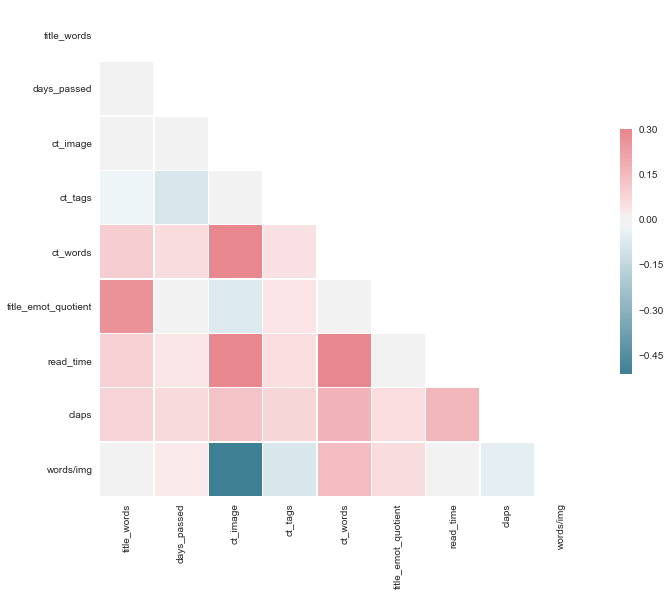

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="white")
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [119]:
corr['claps']

title_words            0.083672
days_passed            0.068105
ct_image               0.128626
ct_tags                0.079793
ct_words               0.175204
title_emot_quotient    0.058537
read_time              0.163609
claps                  1.000000
words/img             -0.048910
Name: claps, dtype: float64